# Classifying Clothing Images

Using the MNSIT fashion dataset

In [65]:
# Import libraries 
import numpy as np 
import pandas as pd 

import torch
from torch import nn, optim 
import torch.nn.functional as F

import matplotlib.pyplot as plt

## Load the data

In [15]:
## Get the data 

from torchvision import datasets, transforms

# Define a transform to normalize the data 
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=0.5, std=0.5)
                              ])


# Download and load the tranining data 
trainset = datasets.FashionMNIST(
            root = './data/FashionMNIST',
            train = True,
            download = True,
            transform = transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Get our testset 
testset = datasets.FashionMNIST(
            root = './data/FashionMNIST',
            train = False,
            download = True,
            transform = transform
)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## Build the Neural Network

In [4]:
# Building our network architecture 

class FashionClassifier(nn.Module):
    def __init__(self):
        # Invoke super class constructor
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x): 
        
        # Flatten the inputs 
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Train the network

In [5]:
model = FashionClassifier()
loss_crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [13]:
# Train the network 
epochs = 10

for epoch in range(epochs): 
    print("Epoch", epochs)
    running_loss = 0
    for images, labels in trainloader:
        log_probs = model(images)
        loss = loss_crit(log_probs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else: 
        print(f"Training Loss: {running_loss}")

Training Loss: 482.3867122977972
Training Loss: 366.37656236439943
Training Loss: 330.79968202114105
Training Loss: 313.2208206728101
Training Loss: 295.9374607503414
Training Loss: 287.22561002522707
Training Loss: 271.61869348585606
Training Loss: 265.2275680489838
Training Loss: 260.74086913466454
Training Loss: 250.74555337429047


## Inference and Validation

In [58]:
# Get predictions on the test data 
images, labels = next(iter(testloader))

# Get the class probs 
probs = torch.exp(model(images))

print(probs.shape)

torch.Size([64, 10])


We can get the most likely class with the highest prob using the topk function. 

In [59]:
top_p, top_class = probs.topk(k=1, dim=1)

print(top_class[:10, :])

tensor([[3],
        [9],
        [7],
        [2],
        [2],
        [7],
        [7],
        [2],
        [2],
        [0]])


Check how many predicted classes match each other. 

In [60]:
equals = (top_class == labels.view(*top_class.shape))
print(equals.shape)

torch.Size([64, 1])


In [61]:
# Calculate the mean of the equals 
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"fAccuracy: {accuracy.item() * 100}")

fAccuracy: 85.9375


### Combing the validation pass in the training itself

I will also add a dropout to the forward pass using `nn.dropout` method

In [77]:
# Building our network architecture 

class FashionClassifier(nn.Module):
    def __init__(self):
        # Invoke super class constructor
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x): 
        
        # Flatten the inputs 
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [78]:
model = FashionClassifier()
loss_crit = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs=30
steps=0

train_losses, test_losses, acc = [], [], []
for e in range(epochs):
    print("\nEpoch: ", e+1)
    running_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        
        log_probs = model(images)
        
        loss = loss_crit(log_probs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else: 
        test_loss = 0
        accuracy = 0

        # Turn off the gradients for the validation 
        with torch.no_grad():
            
            for images, labels in testloader:
                log_probs = model(images)
                test_loss += loss_crit(log_probs, labels)

                probs = torch.exp(model(images))

                # get the predicted class 
                top_p, top_class = probs.topk(k=1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader)) 
        test_losses.append(test_loss/len(testloader))
        acc.append(accuracy/len(testloader))
        
        print(f"Training Loss: {running_loss/len(trainloader)}")
        print(f"Test Loss: {test_loss/len(testloader)}")
        print(f"Test Accuracy: {accuracy/len(testloader)}")
        
        


Epoch:  1
Training Loss: 0.5798359969531549
Test Loss: 0.4867266118526459
Test Accuracy: 0.8302238583564758

Epoch:  2
Training Loss: 0.46102330430166555
Test Loss: 0.4343608617782593
Test Accuracy: 0.8519289493560791

Epoch:  3
Training Loss: 0.4274493525309095
Test Loss: 0.442263126373291
Test Accuracy: 0.843233585357666

Epoch:  4
Training Loss: 0.4248504230875705
Test Loss: 0.410408616065979
Test Accuracy: 0.8567930459976196

Epoch:  5
Training Loss: 0.4039513193118547
Test Loss: 0.37347665429115295
Test Accuracy: 0.8682869076728821

Epoch:  6
Training Loss: 0.3939859187488617
Test Loss: 0.4086402952671051
Test Accuracy: 0.8519289493560791

Epoch:  7
Training Loss: 0.4029437857332514
Test Loss: 0.3620277941226959
Test Accuracy: 0.8737840056419373

Epoch:  8
Training Loss: 0.37855344753402637
Test Loss: 0.3495310842990875
Test Accuracy: 0.8745002746582031

Epoch:  9
Training Loss: 0.39219320325582013
Test Loss: 0.3659687638282776
Test Accuracy: 0.8710687756538391

Epoch:  10
Traini

#### Plot our training and validation losses

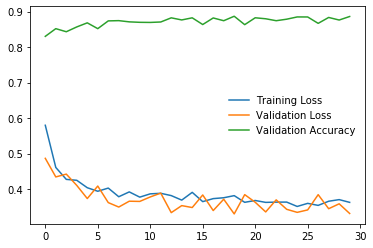

In [79]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label="Validation Loss")
plt.plot(acc, label="Validation Accuracy")
plt.legend(frameon=False)